In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import anndata as ad 
import scanpy as sc
sys.path.append("../../spatial-clust-scripts-main/")
import utils
from sklearn.decomposition import PCA
import umap
import graph
#import visualize
import sklearn.metrics

/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stlearn = pd.read_csv('../../data/tonsil/tonsil_stlearn_pca30v2.csv', index_col=1).to_numpy()
sedr = pd.read_csv('../../data/tonsil/tonsil_sedr_32n_v2.csv', index_col=1).to_numpy()
spagcn = np.load('../../data/tonsil/conv_output_epoch_0.npy')
banksy = pd.read_csv('../../data/tonsil/cellsnap_data_cdxton_banksy_r1-all.csv').loc[:, 'PC1':'PC20'].to_numpy()
cellc = pd.read_csv('../../data/tonsil/CC_tonsil_20x4.csv').to_numpy() #naming error actually pc30

print([stlearn.shape, sedr.shape, spagcn.shape, banksy.shape, cellc.shape])

[(102574, 30), (54011, 32), (54011, 20), (102574, 20), (102574, 120)]


In [3]:
# define modularity score

import leidenalg
import igraph as ig

def get_modularity(n,edges, seed = 42, resolution = 1):
    
    g = ig.Graph(directed=True)
    g.add_vertices(n)
    g.add_edges(list(zip(edges[0], edges[1])))
    g.es['weight'] = tuple(edges[2])
    partition_kwargs = {'n_iterations': -1, 'seed': seed,
                    'resolution_parameter': resolution}
    partition_kwargs['weights'] = np.array(g.es['weight']).astype(np.float64)
    partition_type = leidenalg.RBConfigurationVertexPartition
    curr_part = leidenalg.find_partition(
                graph=g, partition_type=partition_type,
                **partition_kwargs
            )
    curr_modularity = curr_part.modularity
    
    return curr_modularity

In [4]:
# for loop start:
batch = 5
dflist = []
for i in range(batch):
    print('at', i)
    
    indices = np.random.choice(sedr.shape[0], 10000, replace=False)
    
    stlearn_sub = stlearn[indices]
    sedr_sub = sedr[indices]
    spagcn_sub = spagcn[indices]
    banksy_sub = banksy[indices]
    cellc_sub = cellc[indices]
    
    ##### calculate umap
    
    # start to calculate silhoutte score
    stlearn_ss_list = []
    sedr_ss_list = []
    spagcn_ss_list = []
    banksy_ss_list = []
    cellc_ss_list = []
    
    ## stlearn
    stlearn_edges = graph.get_feature_edges(
        arr=stlearn_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )
    
    ## sedr
    sedr_edges = graph.get_feature_edges(
        arr=sedr_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )
    
    ## spagcn
    spagcn_edges = graph.get_feature_edges(
        arr=spagcn_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )

    ## banksy
    banksy_edges = graph.get_feature_edges(
        arr=banksy_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )

    ## cellcharter
    cellc_edges = graph.get_feature_edges(
        arr=cellc_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )

    res_list = [round(x, 2) for x in np.arange (0.4, 2.6, 0.2)]
    
    for res in res_list:
        
        stlearn_ss = get_modularity(stlearn_sub.shape[0], stlearn_edges, resolution = res)
        sedr_ss = get_modularity(sedr_sub.shape[0], sedr_edges, resolution = res)
        spagcn_ss = get_modularity(spagcn_sub.shape[0], spagcn_edges, resolution = res)
        banksy_ss = get_modularity(banksy_sub.shape[0], banksy_edges, resolution = res)
        cellc_ss = get_modularity(cellc_sub.shape[0], cellc_edges, resolution = res)
        
        stlearn_ss_list.append(stlearn_ss)
        sedr_ss_list.append(sedr_ss)
        spagcn_ss_list.append(spagcn_ss)
        banksy_ss_list.append(banksy_ss)
        cellc_ss_list.append(cellc_ss)
        
    data = {'res':res_list, 'ch_stlearn':stlearn_ss_list, 'ch_sedr':sedr_ss_list, 'ch_spagcn':spagcn_ss_list,
           'ch_banksy':banksy_ss_list, 'ch_cellc':cellc_ss_list}
    
    df = pd.DataFrame(data)
    df['batch'] = i
    dflist.append(df)
    
test = pd.concat(dflist)
test2 = test.melt(id_vars=['res'], value_vars=['ch_stlearn', 'ch_sedr', 'ch_spagcn', 'ch_banksy', 'ch_cellc'])
test2.to_csv('../../data/tonsil/Mod_result_tonsil_revloc.csv')


at 0


/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: Th

at 1


/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


at 2


/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


at 3


/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


at 4


/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/bokaizhu/anaconda3/envs/cellsnap/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [3]:
cca = pd.read_csv('../data/cca12_feat.csv').to_numpy()
mofa = pd.read_csv('../data/mofa_fc23.csv').to_numpy()
print([cca.shape, mofa.shape])

[(102574, 12), (102574, 23)]


In [4]:
# define modularity score

import leidenalg
import igraph as ig

def get_modularity(n,edges, seed = 42, resolution = 1):
    
    g = ig.Graph(directed=True)
    g.add_vertices(n)
    g.add_edges(list(zip(edges[0], edges[1])))
    g.es['weight'] = tuple(edges[2])
    partition_kwargs = {'n_iterations': -1, 'seed': seed,
                    'resolution_parameter': resolution}
    partition_kwargs['weights'] = np.array(g.es['weight']).astype(np.float64)
    partition_type = leidenalg.RBConfigurationVertexPartition
    curr_part = leidenalg.find_partition(
                graph=g, partition_type=partition_type,
                **partition_kwargs
            )
    curr_modularity = curr_part.modularity
    
    return curr_modularity

In [5]:
# for loop start:
batch = 5
dflist = []
for i in range(batch):
    print('at', i)
    
    indices = np.random.choice(cca.shape[0], 10000, replace=False)
    
    cca_sub = cca[indices]
    mofa_sub = mofa[indices]
    
    ##### calculate umap
    
    # start to calculate silhoutte score
    cca_ss_list = []
    mofa_ss_list = []
    
    ## feature edges
    cca_edges = graph.get_feature_edges(
            arr=cca_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
    )

    ## snap
    mofa_edges = graph.get_feature_edges(
            arr=mofa_sub, pca_components=None,
            n_neighbors=15, metric='correlation', verbose=False
    )


    res_list = [round(x, 2) for x in np.arange (0.4, 2.6, 0.2)]
    for res in res_list:
        
        cca_ss = get_modularity(cca_sub.shape[0], cca_edges, resolution = res)
        mofa_ss = get_modularity(mofa_sub.shape[0], mofa_edges, resolution = res)
        
        cca_ss_list.append(cca_ss)
        mofa_ss_list.append(mofa_ss)
        
    data = {'res':res_list, 'ch_cca':cca_ss_list,
            'ch_mofa':mofa_ss_list}
    
    df = pd.DataFrame(data)
    df['batch'] = i
    dflist.append(df)
    
test = pd.concat(dflist)
test2 = test.melt(id_vars=['res'], value_vars=['ch_cca', 'ch_mofa'])
test2.to_csv('../data/Mod_result_tonsil_ccamofa.csv')


at 0
at 1
at 2
at 3
at 4


In [2]:
# define modularity score

import leidenalg
import igraph as ig

def get_modularity(n,edges, seed = 42, resolution = 1):
    
    g = ig.Graph(directed=True)
    g.add_vertices(n)
    g.add_edges(list(zip(edges[0], edges[1])))
    g.es['weight'] = tuple(edges[2])
    partition_kwargs = {'n_iterations': -1, 'seed': seed,
                    'resolution_parameter': resolution}
    partition_kwargs['weights'] = np.array(g.es['weight']).astype(np.float64)
    partition_type = leidenalg.RBConfigurationVertexPartition
    curr_part = leidenalg.find_partition(
                graph=g, partition_type=partition_type,
                **partition_kwargs
            )
    curr_modularity = curr_part.modularity
    
    return curr_modularity

In [3]:
# read in files
snap_embed = np.load("../data/double_snap_combo_stable_binVer_0325.npy")
features = np.load("../data/other_methods/features.npy")
concact_embed = np.load("../data/other_methods/concat_embedding.npy")
spice_embed = np.load("../data/other_methods/spicemix_embedding.npy")

##### load in muse 0-4 batch results
muse_embed0 = np.load("../data/other_methods/muse_final_tonsil_rdm10k_0.npy")
muse_embed1 = np.load("../data/other_methods/muse_final_tonsil_rdm10k_1.npy")
muse_embed2 = np.load("../data/other_methods/muse_final_tonsil_rdm10k_2.npy")
muse_embed3 = np.load("../data/other_methods/muse_final_tonsil_rdm10k_3.npy")
muse_embed4 = np.load("../data/other_methods/muse_final_tonsil_rdm10k_4.npy")
muse_embedll = [muse_embed0, muse_embed1, muse_embed2, muse_embed3, muse_embed4]

print([snap_embed.shape, features.shape, concact_embed.shape,
      spice_embed.shape, muse_embed0.shape])

[(102574, 32), (102574, 47), (102574, 63), (102574, 25), (10000, 30)]


In [4]:
# for loop start:
batch = 5
dflist = []
for i in range(batch):
    print('at', i)
    
    indices = np.random.choice(snap_embed.shape[0], 10000, replace=False)
    
    snap_embed_sub = snap_embed[indices]
    features_sub = features[indices]
    concact_embed_sub = concact_embed[indices]
    spice_embed_sub = spice_embed[indices]
    muse_embed_sub = muse_embedll[i]
    
    ##### calculate umap
    
    # start to calculate silhoutte score
    feature_ss_list = []
    snap_ss_list = []
    concact_ss_list = []
    spice_ss_list = []
    muse_ss_list = []
    
    ## feature edges
    feature_edges = graph.get_feature_edges(
        arr=features_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )

    ## snap
    snap_edges = graph.get_feature_edges(
        arr=snap_embed_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )

    ## concact 
    concact_edges = graph.get_feature_edges(
        arr=concact_embed_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )

    ## muse 
    muse_edges = graph.get_feature_edges(
        arr=muse_embed_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )

    ## spice 
    spice_edges = graph.get_feature_edges(
        arr=spice_embed_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )

    res_list = [round(x, 2) for x in np.arange (0.4, 2.6, 0.2)]
    for res in res_list:
        
        feature_ss = get_modularity(features_sub.shape[0], feature_edges, resolution = res)
        snap_ss = get_modularity(snap_embed_sub.shape[0], snap_edges, resolution = res)
        concact_ss = get_modularity(concact_embed_sub.shape[0], concact_edges, resolution = res)
        spice_ss = get_modularity(spice_embed_sub.shape[0], spice_edges, resolution = res)
        muse_ss = get_modularity(muse_embed_sub.shape[0], muse_edges, resolution = res)
        
        feature_ss_list.append(feature_ss)
        snap_ss_list.append(snap_ss)
        concact_ss_list.append(concact_ss)
        spice_ss_list.append(spice_ss)
        muse_ss_list.append(muse_ss)
        
    data = {'res':res_list, 'ch_feature':feature_ss_list,
            'ch_snap':snap_ss_list,'ch_concact':concact_ss_list,
           'ch_spice':spice_ss_list, 'ch_muse':muse_ss_list}
    
    df = pd.DataFrame(data)
    df['batch'] = i
    dflist.append(df)
    


at 0
at 1
at 2
at 3
at 4


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

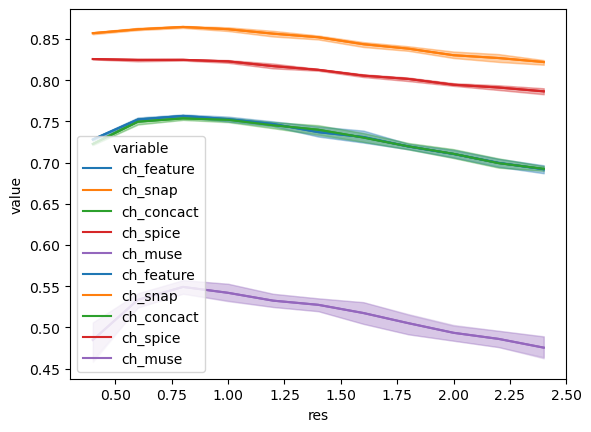

In [5]:
test = pd.concat(dflist)
test2 = test.melt(id_vars=['res'], value_vars=['ch_feature', 'ch_snap', 'ch_concact', 'ch_spice', 'ch_muse'])
test2.to_csv('../data/MOD_result_tonsil_0325.csv')


test = pd.concat(dflist)
test2 = test.melt(id_vars=['res'], value_vars=['ch_feature', 'ch_snap', 'ch_concact', 'ch_spice', 'ch_muse'])
sns.lineplot(data=test2,x="res", y="value", hue="variable")
plot = sns.lineplot(data=test2,x="res", y="value", hue="variable")
fig = plot.get_figure()
#fig.savefig('../plots/Mod_allmethods_v2.svg', dpi = 300) 

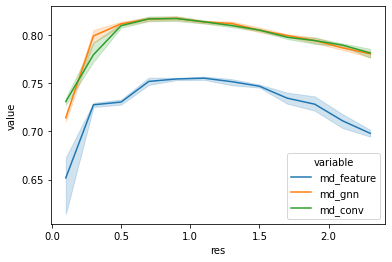

In [9]:
plot = sns.lineplot(data=test2,x="res", y="value", hue="variable")
fig = plot.get_figure()
fig.savefig('../plots/Modularity.svg', dpi = 300) 

## without gnn version

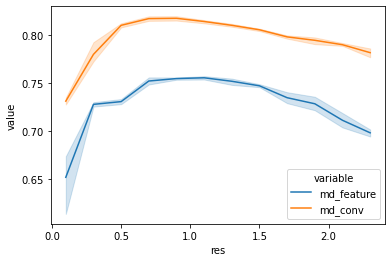

In [10]:
test = pd.concat(dflist)
test2 = test.melt(id_vars=['res'], value_vars=['md_feature', 'md_conv'])

plot = sns.lineplot(data=test2,x="res", y="value", hue="variable")
fig = plot.get_figure()
fig.savefig('../plots/Modularity_wo_gnn.svg', dpi = 300) 